# 프로젝트: 뉴스 요약봇 만들기

## 1. 라이브러리 불러오기 & 경로 설정

In [1]:
# 데이터 로드
import pandas as pd
import urllib.request

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from torch.nn.utils.rnn import pad_sequence

# 추상적 요약 라이브러리
from importlib.metadata import version
import nltk
from nltk.corpus import stopwords
import re

# 추출적 요약 라이브러리
from summa import summarizer
from summa import keywords
from summa import commons
from summa import pagerank_weighted

# 모델 설계
import torch
import torch.nn as nn
import torch.nn.functional as F

# 모델 훈련
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 기타 헬퍼 라이브러리
import os
import numpy as np
from bs4 import BeautifulSoup
import random
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(torch.__version__)
print(pd.__version__)
print(version('summa'))

3.9.2
2.7.1+cu118
2.3.0
1.2.0


## 2. 데이터 분석

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

('news_summary_more.csv', <http.client.HTTPMessage at 0x7dc715a7b410>)

In [3]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
pd.set_option('display.max_colwidth', 500) # 열 디스플레이 옵션 설정

In [4]:
# 샘플 확인 
data.sample(10)

,headlines,text
11179,91% new PCs from India have pirated software: Microsoft,"Over 90% new PCs purchased by Microsoft from India have pirated software, Microsoft said. The company tested them to find that 83% of the PCs acquired from nine Asian countries had pirated software. India was followed by Indonesia (90%), Taiwan (73%), Singapore (55%) and the Philippines (43%). PCs from South Korea, Malaysia, Vietnam and Thailand had 100% pirated software."
24956,Uber driver livestreams riders without consent in US,"Jason Gargac, an Uber driver in Missouri, US, live-streamed hundreds of riders without their consent on video platform Twitch, according to a report. Gargac recorded the interior of his car during the rides with a camera, allowing his followers to see and comment on the faces of his passengers. Uber has suspended the driver claiming violation of its rules."
88596,US man jailed 49 yrs in first-ever transgender hate crime,"In the first-ever transgender hate crime prosecution in the US, a Mississippi man, Joshua Vallum, has been sentenced to 49 years in prison for the murder of his former transgender girlfriend in 2015. Vallum decided to kill her fearing that he could face retribution if word spread that she was a transgender woman, prosecutors said."
81992,Volvo to use electric engines in all cars from 2019,"All Volvo car models launched after 2019 will be electric or hybrid, the Swedish company said on Wednesday. Volvo is now among the first major traditional automakers to set a date for phasing out vehicles powered solely by an internal combustion engine. The carmaker has also announced a project to launch self-driving cars by 2021."
83243,Ivanka told to testify in case of brand copying shoe design,"US President Donald Trump's daughter Ivanka Trump has been ordered to give a deposition in a lawsuit claiming her brand plagiarised a shoe design. Trump's lawyers had earlier filed a motion to prevent her from testifying. An Italian shoe company sued Ivanka's brand, alleging that it created an identical copy of one of their shoe models called the ""Wild Thing""."
39025,Cong leader likens ex-Prez's fake photo to Nazi propaganda,"Referring to former President Pranab Mukherjee's morphed photo at an RSS event, Congress leader Manish Tewari said, ""[A]s the Nazi Propaganda Minister Joseph Goebbels famously quipped you speak a lie a thousand times it will become the truth."" He added that the morphed picture of the former President was for posterity and not for today."
2073,India's football coach quits after India's Asian Cup exit,Stephen Constantine resigned as the Indian football team's head coach after India were knocked out of the AFC Asian Cup following a 1-0 defeat by Bahrain on Monday. Constantine said that he was stepping down after having achieved the target of helping India qualify for the Asian Cup after a gap of eight years.
89803,Japan has a hotel for dead people,"A corpse hotel named Lastel offers rooms for the dead in Japan. The hotel seeks to provide space for the dead bodies, while they wait for crematoriums. The white and grey tiled building can usually accommodate 18 deceased guests, tucked up in refrigerated coffins. The daily rate at the hotel is about Ã¢ÂÂ¹6,800 (12,000 yen)."
39536,No woman featured in world's highest-paid 100 athletes,"Forbes list of the world's highest-paid athletes has featured no woman this year while tennis star Serena Williams was the lone female athlete in top 100 last year. Williams' prize money dropped from $8 million to $62,000 as she gave birth last September while Maria Sharapova, who was also featured earlier, faced a 15-month suspension for using a banned substance."
83965,"ISIS-inspired fake Lego set has terrorists, chainsaws, bombs","A Chinese retailer is selling Islamic State-inspired counterfeit Lego sets, featuring terrorists armed with chainsaws and a decapitated head. The 'Falcon Commandos' set claims to pitch ""intelligence officers"" against ISIS terrorists. Following t

In [5]:
# 전체 기사 건 수 확인 
print("뉴스 기사 건 수:", len(data))

뉴스 기사 건 수: 98401


In [6]:
# 중복값 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# 중복값 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# 결측값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


본문의 최소 길이 : 1
본문의 최대 길이 : 91
본문의 평균 길이 : 58.23813542090281


제목의 최소 길이 : 1
제목의 최대 길이 : 18
제목의 평균 길이 : 9.553660024400163






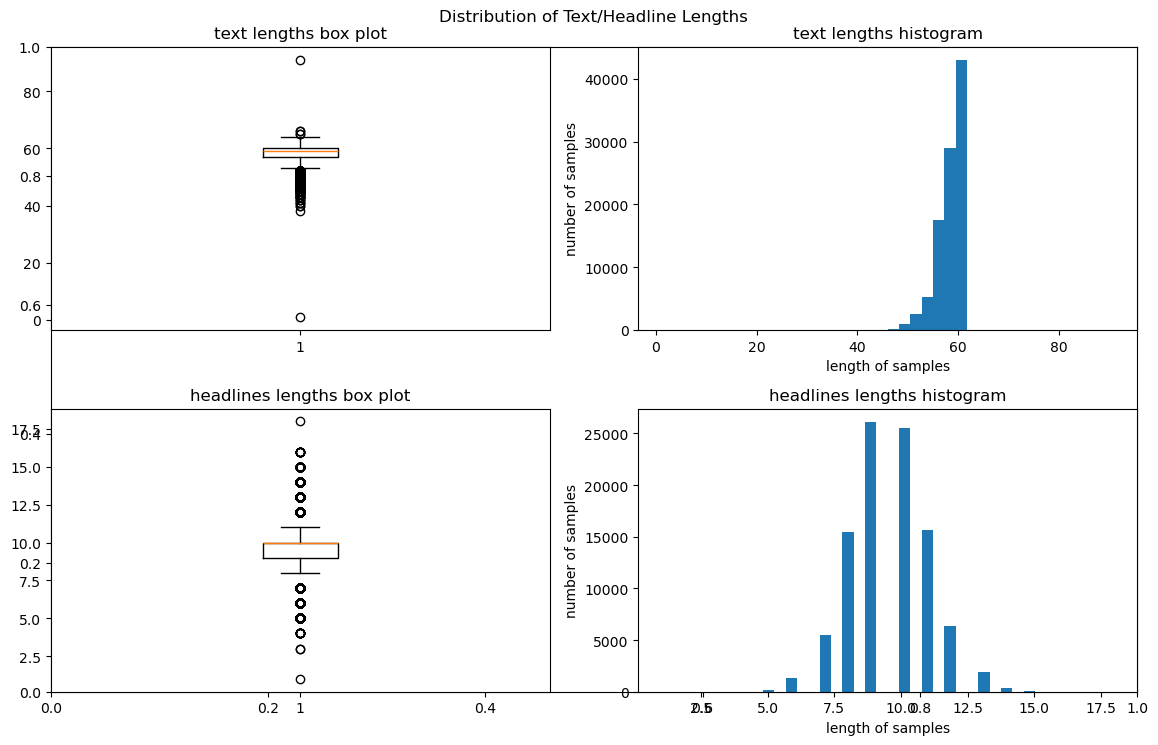

In [9]:
# 뉴스별 기사 길이 분포 확인
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('본문의 최소 길이 : {}'.format(np.min(text_len)))
print('본문의 최대 길이 : {}'.format(np.max(text_len)))
print('본문의 평균 길이 : {}'.format(np.mean(text_len)))
print("\n")
print('제목의 최소 길이 : {}'.format(np.min(summary_len)))
print('제목의 최대 길이 : {}'.format(np.max(summary_len)))
print('제목의 평균 길이 : {}'.format(np.mean(summary_len)))
print("\n")

print("=" * 80)
print("\n")

plt.figure(figsize=(12, 8))
plt.title("Distribution of Text/Headline Lengths\n")

plt.subplot(2,2,1)
plt.boxplot(text_len)
plt.title('text lengths box plot')

plt.subplot(2,2,2)
plt.title('text lengths histogram')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.subplot(2,2,3)
plt.boxplot(summary_len)
plt.title('headlines lengths box plot')

plt.subplot(2,2,4)
plt.title('headlines lengths histogram')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.tight_layout()
plt.show()

## 3. 텍스트 요약

### 3-1. 추상적 요약

#### 데이터 전처리

In [10]:
# 정규화 사전 정의
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# 불용어 사전 정의
nltk.download('stopwords')
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...


불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
def preprocess_sentence(sentence, remove_stopwords=True, keep_numbers=True):
    """
    뉴스 기사 전처리 함수
    
    Parameters:
    sentence : str
        전처리할 문장
    remove_stopwords : bool, default=True
        불용어 제거 여부 (Text용 True, Summary용 False)
    keep_numbers : bool, default=True
        숫자 유지 여부
    
    Returns:
    str
        전처리된 문장
    """
    # 1. 텍스트 소문자화
    sentence = sentence.lower()
    
    # 2. HTML 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text
    
    # 3. URL 제거
    sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)
    
    # 4. 이메일 주소 제거
    sentence = re.sub(r'\S+@\S+', '', sentence)
    
    # 5. 괄호로 닫힌 문자열 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    
    # 6. 쌍따옴표 제거
    sentence = re.sub('"', '', sentence)
    
    # 7. 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    
    # 8. 소유격 제거
    sentence = re.sub(r"'s\b", "", sentence)
    
    # 9. 하이픈 처리 (하이픈으로 연결된 단어를 공백으로 분리)
    sentence = re.sub(r'-', ' ', sentence)
    
    # 10. 영어와 숫자 외 문자 제거 (숫자 유지 옵션에 따라)
    if keep_numbers:
        sentence = re.sub(r"[^a-zA-Z0-9\s]", " ", sentence)  # 숫자 유지
    else:
        sentence = re.sub(r"[^a-zA-Z\s]", " ", sentence)  # 숫자 제거
    
    # 11. m이 3개 이상이면 2개로 변경
    sentence = re.sub(r'[m]{2,}', 'mm', sentence)
    
    # 12. 반복 공백 제거
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # 13. 양쪽 공백 제거
    sentence = sentence.strip()
    
    # 14. 불용어 제거 및 짧은 단어 제거
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() 
                         if word not in stopwords.words('english') 
                         and len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() 
                         if len(word) > 1)
    
    return tokens

In [17]:
# 전체 text 데이터에 대한 전처리
clean_text = []
for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence, remove_stopwords=True, keep_numbers=True))

# 전처리 후 출력
print("Text 전처리 후 결과:")
print(clean_text[:5])
print(f"\n전처리 완료: 총 {len(clean_text)}개")

# 전체 summary(Headlines) 데이터에 대한 전처리
clean_summary = []
for sentence in data['headlines']:
    clean_summary.append(preprocess_sentence(sentence, remove_stopwords=False, keep_numbers=True))

# 전처리 후 출력
print("\nSummary 전처리 후 결과:")
print(clean_summary[:5])
print(f"전처리 완료: 총 {len(clean_summary)}개")

# 데이터프레임에 추가
data['clean_text'] = clean_text
data['clean_summary'] = clean_summary

Text 전처리 후 결과:
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 100 y

In [13]:
# 저장한 전처리 데이터 불러오기
data = pd.read_csv('cleaned_data.csv', encoding='iso-8859-1')
data.head()

,headlines,text,clean_text,clean_summary
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.",saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered lakh careers,upgrad learner switches to career in ml al with 90 salary hike
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.",kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit,delhi techie wins free food from swiggy for one year on cred
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,"New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.",new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history,new zealand end rohit sharma led india 12 match winning streak
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to ÃÂ¢ÃÂÃÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.",aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 100 years also customers options insure critical illnesses disability accidental death benefit rider life cover age 80 years,aegon life iterm insurance plan helps customers save tax
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""In the #MeToo movement, I always believe a woman. But in this case, we need to reserve our judgment,"" she added. Hirani has been accused by an assistant who worked in 'Sanju'.",speaking sexual harassment allegations rajkumar hirani sonam kapoor said known hirani many years true metoo movement get derailed metoo movement always believe woman case need reserve judgment added hirani accused assistant worked sanju,have known hirani for yrs what if metoo claims are not true sonam


In [14]:
# 전처리 전후 비교 (샘플 3개)
for i in range(3):
    print(f"\n[샘플 {i+1}]")
    print(f"원본 Text: {data['text'].iloc[i][:100]}...")
    print(f"전처리 Text: {data['clean_text'].iloc[i][:100]}...")
    print(f"\n원본 Summary: {data['headlines'].iloc[i]}")
    print(f"전처리 Summary: {data['clean_summary'].iloc[i]}")
    print("-" * 80)


[샘플 1]
원본 Text: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelli...
전처리 Text: saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engin...

원본 Summary: upGrad learner switches to career in ML & Al with 90% salary hike
전처리 Summary: upgrad learner switches to career in ml al with 90 salary hike
--------------------------------------------------------------------------------

[샘플 2]
원본 Text: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swig...
전처리 Text: kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pr...

원본 Summary: Delhi techie wins free food from Swiggy for one year on CRED
전처리 Summary: delhi techie wins free food from swiggy for one year on cred
--------------------------------------------------------------------------------

[샘플 3]
원본 Text: New Zealand defeated India by 8 wickets in the f

In [15]:
# 빈 문장이나 너무 짧은 문장 확인
empty_text = data[data['clean_text'].str.strip() == '']
empty_summary = data[data['clean_summary'].str.strip() == '']

print(f"\n=== 빈 문장 확인 ===")
print(f"빈 Text: {len(empty_text)}개")
print(f"빈 Summary: {len(empty_summary)}개")

# 너무 짧은 문장 (3단어 미만) - 즉석에서 길이 계산
short_text = data[data['clean_text'].apply(lambda x: len(x.split())) < 3]
short_summary = data[data['clean_summary'].apply(lambda x: len(x.split())) < 3]

print(f"\n너무 짧은 Text (3단어 미만): {len(short_text)}개")
print(f"너무 짧은 Summary (3단어 미만): {len(short_summary)}개")


=== 빈 문장 확인 ===
빈 Text: 0개
빈 Summary: 0개

너무 짧은 Text (3단어 미만): 1개
너무 짧은 Summary (3단어 미만): 1개


In [16]:
# 텍스트 길이 자르기
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, 100 * (cnt / len(nested_list))))

In [17]:
# 본문, 제목 최대 길이 설정
text_max_len = 55
summary_max_len = 12

below_threshold_len(text_max_len, data['clean_text'])
below_threshold_len(summary_max_len, data['clean_summary'])

전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.99694997966652
전체 샘플 중 길이가 12 이하인 샘플의 비율: 97.90870272468483


In [18]:
# 샘플 길이 자르기 
data = data[data['clean_text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['clean_summary'].apply(lambda x: len(x.split()) <= summary_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96300


In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['clean_summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['clean_summary'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,clean_text,clean_summary,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.",saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered lakh careers,upgrad learner switches to career in ml al with 90 salary hike,sostoken upgrad learner switches to career in ml al with 90 salary hike,upgrad learner switches to career in ml al with 90 salary hike eostoken
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.",kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit,delhi techie wins free food from swiggy for one year on cred,sostoken delhi techie wins free food from swiggy for one year on cred,delhi techie wins free food from swiggy for one year on cred eostoken
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,"New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.",new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history,new zealand end rohit sharma led india 12 match winning streak,sostoken new zealand end rohit sharma led india 12 match winning streak,new zealand end rohit sharma led india 12 match winning streak eostoken
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to ÃÂ¢ÃÂÃÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.",aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 100 years also customers options insure critical illnesses disability accidental death benefit rider life cover age 80 years,aegon life iterm insurance plan helps customers save tax,sostoken aegon life iterm insurance plan helps customers save tax,aegon life iterm insurance plan helps customers save tax eostoken
5,Rahat Fateh Ali Khan denies getting notice for smuggling currency,"Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India. ""It would have been better if the authorities would have served the notice first if any and then pub

In [20]:
# 훈련 데이터와 테스트 데이터 분리
encoder_input = np.array(data['clean_text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[24697 32311 62800 ... 65889 11332 61832]


In [22]:
# 샘플 순서 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
# 8:2 비율로 데이터 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19260


In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77040
훈련 레이블의 개수 : 77040
테스트 데이터의 개수 : 19260
테스트 레이블의 개수 : 19260


In [25]:
# 토크나이저 정의
def src_tokenizer(text):
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [26]:
# 단어별 등장 횟수 파악
threshold = 7

# 전처리된 데이터 사용
text_data = data['clean_text'].tolist()
summary_data = data['clean_summary'].tolist()

# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 78492
등장 빈도가 6번 이하인 희귀 단어의 수: 53166
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 25326
단어 집합에서 희귀 단어의 비율: 67.73429139275339
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.079525869267749


In [27]:
src_vocab_size = 8000 # 단어 집합 크기 제한

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)

In [28]:
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[5670, 82, 1, 42, 9, 7593, 1, 743, 212, 1, 1, 6162, 2049, 3935, 3165, 744, 4698, 4046, 5, 6605, 1393, 3935, 1240, 3165, 744, 5578, 4580, 1223, 1076, 3936, 797, 3014, 202, 1945], [422, 27, 1663, 259, 404, 547, 1, 891, 1503, 1, 743, 1, 297, 408, 113, 1663, 732, 402, 1428, 1394, 1636, 3166, 846, 732, 36, 3118, 98, 21, 2, 1663, 1, 635, 1375, 3508, 806, 146, 1], [4332, 90, 1, 1, 1001, 39, 445, 1507, 59, 156, 4332, 90, 118, 1153, 109, 686, 19, 1325, 59, 1169, 1327, 1, 1, 1132, 1, 2, 3660, 758, 198, 139, 935, 758, 5]]
[[12, 284, 3576, 653, 2851, 284, 3653, 171, 63, 3375, 89, 857, 91, 917, 3109, 482, 706, 237, 4830, 5319, 33, 1, 300, 10, 698, 1, 37, 1181, 158, 1296, 6358, 1683, 7021, 573, 2905, 693, 7198], [1, 2686, 1521, 556, 3880, 1, 1, 42, 6714, 52, 3697, 123, 2927, 1, 347, 300, 7937, 4190, 6714, 1397, 3697, 123, 1836, 1, 1, 1716, 693, 4408, 123, 1, 4190, 2760, 6381, 1407, 645], [183, 206, 1, 267, 1210, 190, 2525, 318, 1219, 287, 104, 61, 392, 9, 505, 690, 4738, 4184, 1750, 48, 15, 869, 58

In [29]:
# target (headlines) 에도 동일한 전처리 적용
def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)

In [30]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31830
등장 빈도가 5번 이하인 희귀 단어의 수: 21106
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10724
단어 집합에서 희귀 단어의 비율: 66.30851398052152
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.960399187079361


In [31]:
tar_vocab_size = 2000 # 단어 집합 크기 제한 
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 299, 1, 1, 1, 1619, 1, 37], [2, 807, 47, 564, 944, 1315, 250, 15, 1075, 1], [2, 1, 117, 529, 43, 15, 1, 929, 8, 224], [2, 443, 328, 1, 4, 1, 1947, 5, 334, 541], [2, 42, 20, 1, 14, 12, 721, 1, 290]]
target
decoder  [[299, 1, 1, 1, 1619, 1, 37, 3], [807, 47, 564, 944, 1315, 250, 15, 1075, 1, 3], [1, 117, 529, 43, 15, 1, 929, 8, 224, 3], [443, 328, 1, 4, 1, 1947, 5, 334, 541, 3], [42, 20, 1, 14, 12, 721, 1, 290, 3]]


In [32]:
# 시작 또는 종료 토큰만 남은 샘플 제거 (길이 == 1)
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77040
훈련 레이블의 개수 : 77040
테스트 데이터의 개수 : 19260
테스트 레이블의 개수 : 19260


In [33]:
# 패딩 추가
def convert_to_tensor(sequences): # 텐서 변환 함수 (리스트 → PyTorch 텐서)
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, 
                               padding_value=padding_value, 
                               padding_side='left') # pre-padding
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=summary_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=summary_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=summary_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=summary_max_len)

In [34]:
# 패딩 적용 확인
print(encoder_input_train[:3])

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0, 5670,   82,    1,   42,
            9, 7593,    1,  743,  212,    1,    1, 6162, 2049, 3935, 3165,  744,
         4698, 4046,    5, 6605, 1393, 3935, 1240, 3165,  744, 5578, 4580, 1223,
         1076, 3936,  797, 3014,  202, 1945],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,  422,   27, 1663,  259,  404,  547,    1,
          891, 1503,    1,  743,    1,  297,  408,  113, 1663,  732,  402, 1428,
         1394, 1636, 3166,  846,  732,   36, 3118,   98,   21,    2, 1663,    1,
          635, 1375, 3508,  806,  146,    1],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0, 4332,   90,    1,
            1, 1001,   39,  445, 1507,   59,  156, 4332,   90,  118, 1153,  109,
          686,   

#### 모델 설계

In [46]:
# 인코더 설계
class Encoder(nn.Module):
    """
    양방향 LSTM을 사용하는 인코더
    - 양방향 LSTM: 문장을 앞뒤로 모두 읽어 문맥을 더 잘 이해
    - Dropout: 과적합 방지
    """
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 임베딩 층: 단어 인덱스를 벡터로 변환
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # 양방향 LSTM 사용 (bidirectional=True)
        # 양방향이므로 실제 hidden_size는 절반으로 설정
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_size // 2,  # 양방향이므로 절반 크기 사용
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,  # 층이 1개면 dropout 불필요
            batch_first=True,
            bidirectional=True  # 양방향 LSTM
        )
        
        # Dropout 층 추가
        self.dropout = nn.Dropout(dropout)
    
    def _combine_bidirectional(self, state):
        """양방향 LSTM의 forward와 backward 상태를 결합"""
        # state shape: (num_layers*2, batch_size, hidden_size//2)
        batch_size = state.size(1)
        # forward와 backward를 분리
        forward = state[0:state.size(0):2]  # 짝수 인덱스
        backward = state[1:state.size(0):2]  # 홀수 인덱스
        # concat
        combined = torch.cat([forward, backward], dim=2)  # (num_layers, batch_size, hidden_size)
        return combined
        
    def forward(self, x):
        """
        Args:
            x: 인코더 입력 (batch_size, seq_len)
        Returns:
            outputs: 모든 타임스텝의 hidden state (batch_size, seq_len, hidden_size)
            hidden: 마지막 hidden state (num_layers, batch_size, hidden_size)
            cell: 마지막 cell state (num_layers, batch_size, hidden_size)
        """
        # 임베딩 + Dropout
        embedded = self.dropout(self.embedding(x))  # (batch_size, seq_len, embedding_dim)
        
        # LSTM 실행
        outputs, (hidden, cell) = self.lstm(embedded)
        # outputs: (batch_size, seq_len, hidden_size)
        # hidden/cell: (num_layers*2, batch_size, hidden_size//2) - 양방향이므로 *2
        
        # 양방향 hidden state를 결합 (forward + backward)
        # hidden shape: (num_layers*2, batch_size, hidden_size//2)
        # -> (num_layers, batch_size, hidden_size)
        hidden = self._combine_bidirectional(hidden)
        cell = self._combine_bidirectional(cell)
        
        return outputs, hidden, cell

In [36]:
# Luong 스타일 어텐션 메커니즘
class LuongAttention(nn.Module):
    """
    Luong et al. 2015의 dot-product 어텐션
    - 디코더의 현재 hidden state와 인코더의 모든 hidden states 간의 유사도 계산
    - Softmax로 정규화하여 가중치 생성
    - 가중합으로 context vector 생성
    """
    def __init__(self, hidden_size):
        super(LuongAttention, self).__init__()
        self.hidden_size = hidden_size
        
    def forward(self, decoder_hidden, encoder_outputs, mask=None):
        """
        Args:
            decoder_hidden: 디코더의 현재 hidden state (batch_size, 1, hidden_size)
            encoder_outputs: 인코더의 모든 outputs (batch_size, src_len, hidden_size)
            mask: 패딩 마스크 (batch_size, src_len) - 패딩 위치는 True
        Returns:
            context: 어텐션 적용된 context vector (batch_size, 1, hidden_size)
            attn_weights: 어텐션 가중치 (batch_size, 1, src_len)
        """
        # Dot-product 어텐션 스코어 계산
        # (batch_size, 1, hidden_size) x (batch_size, hidden_size, src_len)
        # -> (batch_size, 1, src_len)
        attn_scores = torch.bmm(decoder_hidden, encoder_outputs.transpose(1, 2))
        
        # 패딩 마스킹 (선택사항이지만 성능 향상에 도움)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask.unsqueeze(1), float('-inf'))
        
        # Softmax로 정규화하여 어텐션 가중치 생성
        attn_weights = F.softmax(attn_scores, dim=-1)  # (batch_size, 1, src_len)
        
        # Context vector 계산 (가중합)
        # (batch_size, 1, src_len) x (batch_size, src_len, hidden_size)
        # -> (batch_size, 1, hidden_size)
        context = torch.bmm(attn_weights, encoder_outputs)
        
        return context, attn_weights

In [37]:
# 디코더 설계
class Decoder(nn.Module):
    """
    어텐션이 통합된 LSTM 디코더
    - 각 타임스텝마다 어텐션을 계산하여 context 반영
    """
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 임베딩 층
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM 층
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, hidden, cell):
        """
        Args:
            x: 디코더 입력 (batch_size, seq_len)
            hidden: 초기 hidden state (num_layers, batch_size, hidden_size)
            cell: 초기 cell state (num_layers, batch_size, hidden_size)
        Returns:
            outputs: LSTM outputs (batch_size, seq_len, hidden_size)
            hidden: 최종 hidden state
            cell: 최종 cell state
        """
        # 임베딩 + Dropout
        embedded = self.dropout(self.embedding(x))  # (batch_size, seq_len, embedding_dim)
        
        # LSTM 실행 (초기 상태를 인코더에서 받음)
        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # outputs: (batch_size, seq_len, hidden_size)
        
        return outputs, hidden, cell

In [38]:
# Seq2Seq with Attention (통합 모델)
class Seq2SeqWithAttention(nn.Module):
    """
    어텐션 메커니즘이 통합된 Seq2Seq 모델
    1. 양방향 인코더
    2. Residual connection (잔차 연결)
    3. Layer Normalization
    4. Padding masking
    5. Dropout
    """
    def __init__(self, encoder, decoder, vocab_size, hidden_size, dropout=0.3):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = LuongAttention(hidden_size)
        
        # 어텐션 결합을 위한 선형 변환
        # decoder output + context를 결합 (hidden_size * 2 -> hidden_size)
        self.concat_layer = nn.Linear(hidden_size * 2, hidden_size)
        
        # Layer Normalization (학습 안정화)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        # 최종 출력층
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, encoder_input, decoder_input):
        """
        Args:
            encoder_input: 인코더 입력 (batch_size, src_len)
            decoder_input: 디코더 입력 (batch_size, tar_len)
        Returns:
            output: 최종 출력 (batch_size, tar_len, vocab_size)
        """
        # 1. 인코더 실행
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        # encoder_outputs: (batch_size, src_len, hidden_size)
        
        # 2. 디코더 실행 (인코더의 마지막 상태를 초기 상태로 사용)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)
        # decoder_outputs: (batch_size, tar_len, hidden_size)
        
        # 3. 각 타임스텝마다 어텐션 적용
        batch_size, tar_len, hidden_size = decoder_outputs.size()
        
        # 어텐션을 위한 마스크 생성 (인코더 입력의 패딩 위치)
        encoder_mask = (encoder_input == 0)  # (batch_size, src_len)
        
        # 각 타임스텝의 context vector를 저장할 텐서
        contexts = []
        
        for t in range(tar_len):
            # 현재 타임스텝의 디코더 hidden state
            decoder_hidden_t = decoder_outputs[:, t:t+1, :]  # (batch_size, 1, hidden_size)
            
            # 어텐션 계산
            context_t, _ = self.attention(decoder_hidden_t, encoder_outputs, encoder_mask)
            # context_t: (batch_size, 1, hidden_size)
            
            contexts.append(context_t)
        
        # 모든 타임스텝의 context를 결합
        context_vectors = torch.cat(contexts, dim=1)  # (batch_size, tar_len, hidden_size)
        
        # 4. 디코더 출력과 context vector를 결합
        # Concatenate: [decoder_output; context]
        combined = torch.cat([decoder_outputs, context_vectors], dim=-1)
        # combined: (batch_size, tar_len, hidden_size * 2)
        
        # 5. 선형 변환 + tanh 활성화
        concat_output = torch.tanh(self.concat_layer(combined))
        # concat_output: (batch_size, tar_len, hidden_size)
        
        # 6. Residual connection (잔차 연결) - 디코더 출력을 더해줌
        # 이를 통해 gradient flow 개선
        concat_output = concat_output + decoder_outputs
        
        # 7. Layer Normalization
        concat_output = self.layer_norm(concat_output)
        
        # 8. Dropout
        concat_output = self.dropout(concat_output)
        
        # 9. 최종 출력층 (vocab_size 차원으로 투영)
        output = self.output_layer(concat_output)
        # output: (batch_size, tar_len, vocab_size)
        
        return output

#### 모델 훈련

In [47]:
# 모델 생성 및 초기화

# 하이퍼파라미터
embedding_dim = 128
hidden_size = 256
num_layers = 3
dropout = 0.4

# 인코더, 디코더 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers, dropout)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers, dropout)

# Seq2Seq 모델 생성
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size, dropout=0.3)

In [48]:
# GPU 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(8000, 128, padding_idx=0)
    (lstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(2000, 128, padding_idx=0)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (attention): LuongAttention()
  (concat_layer): Linear(in_features=512, out_features=256, bias=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output_layer): Linear(in_features=256, out_features=2000, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [49]:
# 하이퍼파라미터 정의
batch_size = 256
epochs = 50
learning_rate = 0.001
patience = 4

In [50]:
# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [51]:
# 훈련 함수 정의
train_losses = []
val_losses = []

# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

In [ ]:
# 모델 훈련
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

In [ ]:
# loss 변화 추이 시각화
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

#### 모델 테스트

### 3-2. 추출적 요약

#### `ratio` 결정

In [38]:
def analyze_text_summarization(data, n=10, ratios=[0.2, 0.4, 0.6], random_state=42):
    """
    텍스트 요약 분석 함수
    
    Parameters:
    data : pd.DataFrame
        'headlines'와 'text' 컬럼을 포함한 데이터프레임
    n : int, default=10
        추출할 샘플 개수
    ratios : list, default=[0.2, 0.4, 0.6]
        요약 비율 리스트
    random_state : int, default=42
        재현성을 위한 랜덤 시드
    """
    # 무작위로 n개의 샘플 추출
    samples = data.sample(n=n, random_state=random_state)
    print(f"추출된 뉴스 제목들:\n{samples['headlines'].values}\n")
    
    # 각 샘플에 대해 반복
    for idx, row in samples.iterrows():
        headline = row['headlines']
        text = row['text']
        
        # 문장 분리 및 영향력 점수 계산
        sentences = [s.strip() for s in text.split('.') if len(s.strip()) > 5]
        graph = commons.build_graph(sentences)
        summarizer._set_graph_edge_weights(graph)
        commons.remove_unreachable_nodes(graph)
        scores = pagerank_weighted.pagerank_weighted_scipy(graph) # Pagerank 알고리즘 적용
        
        # 결과 출력 시작
        print(f"{'='*60}")
        print(f"제목: {headline}")
        print(f"본문: {text}")
        print(f"{'='*60}\n")
        
        # Ratio 변화에 따른 요약 결과 출력
        for r in ratios:
            result = summarizer.summarize(text, ratio=r)
            
            # 요약 결과가 비어있을 경우 처리
            if not result:
                result = f"(Ratio {r}로는 문장이 추출되지 않았습니다.)"
            
            print(f"[Ratio {r}] 요약 결과:")
            print(f"{result}")
            print(f"{'-'*40}")
        
        # 문장별 점수 데이터프레임 생성 및 출력
        analysis_df = pd.DataFrame({
            'order': range(1, len(sentences) + 1),
            'score': [scores.get(s, 0) for s in sentences],
            'sentence': sentences
        })
        
        display(analysis_df[['order', 'score', 'sentence']].style.hide(axis='index'))
        print()  # 샘플 간 구분을 위한 빈 줄

In [41]:
analyze_text_summarization(data, n=10, ratios=[0.3, 0.5, 0.7])

추출된 뉴스 제목들:
['Paytm raises $1.4 billion from SoftBank in largest funding '
 'Petrol price cut by Ã¢Â\x82Â¹1.12 per litre as daily revision starts'
 'Army plans to deploy women officers for cyber warfare'
 'Uday Chopra confirms YRF will produce Jessica Chastain film'
 'Mulayam Yadav to contest 2019 polls from Mainpuri: SP leader'
 "I am so excited to play under Virat Kohli's captaincy: Shubman Gill"
 'Twitter reacts to women-only screening of Wonder Woman in US'
 'Apple to hire engineer with psychology background for Siri'
 'Railway Board Chairman resigns after 2 derailments in 4 days'
 'Who is billionaire Radhakishan Damani?']

제목: Paytm raises $1.4 billion from SoftBank in largest funding 
본문: Digital payments startup Paytm has raised $1.4 billion from SoftBank in India's largest funding round. This is also SoftBank's biggest investment in the Indian startup ecosystem till date. The latest investment by SoftBank will value Paytm at around $8 billion, up from its valuation of $4.8 bill

order,score,sentence
1,0.267012,Digital payments startup Paytm has raised $1
2,0.589509,4 billion from SoftBank in India's largest funding round
3,0.471933,This is also SoftBank's biggest investment in the Indian startup ecosystem till date
4,0.435376,"The latest investment by SoftBank will value Paytm at around $8 billion, up from its valuation of $4"
5,0.410988,8 billion in August 2016



제목: Petrol price cut by Ã¢ÂÂ¹1.12 per litre as daily revision starts
본문: Oil companies on Thursday reduced the petrol price by Ã¢ÂÂ¹1.12/litre and diesel by Ã¢ÂÂ¹1.24/litre effective June 16. This is the first cut in prices following the decision to revise fuel prices daily and the revision shall be applicable from 6 AM to 6 AM the next day. Customers can know the revised prices through social media posts and 'Fuel@IOC' app.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
Customers can know the revised prices through social media posts and 'Fuel@IOC' app.
----------------------------------------
[Ratio 0.7] 요약 결과:
This is the first cut in prices following the decision to revise fuel prices daily and the revision shall be applicable from 6 AM to 6 AM the next day.
Customers can know the revised prices through social media posts and 'Fuel@IOC' app.
----------------------------------------


order,score,sentence
1,0.487366,Oil companies on Thursday reduced the petrol price by Ã¢ÂÂ¹1
2,0.515931,12/litre and diesel by Ã¢ÂÂ¹1
3,0.000000,24/litre effective June 16
4,0.480703,This is the first cut in prices following the decision to revise fuel prices daily and the revision shall be applicable from 6 AM to 6 AM the next day
5,0.514990,Customers can know the revised prices through social media posts and 'Fuel@IOC' app



제목: Army plans to deploy women officers for cyber warfare
본문: The Indian Army has announced plans to deploy women officers for cyber warfare as they face cybersecurity threats from both state and non-state actors. In order to increase the number of female officers and provide them more opportunities, the Army is also planning to hire 850 of women in the military police branch and some in the language training branch.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
The Indian Army has announced plans to deploy women officers for cyber warfare as they face cybersecurity threats from both state and non-state actors.
----------------------------------------
[Ratio 0.7] 요약 결과:
The Indian Army has announced plans to deploy women officers for cyber warfare as they face cybersecurity threats from both state and non-state actors.
----------------------------------------


order,score,sentence
1,0.707107,The Indian Army has announced plans to deploy women officers for cyber warfare as they face cybersecurity threats from both state and non-state actors
2,0.707107,"In order to increase the number of female officers and provide them more opportunities, the Army is also planning to hire 850 of women in the military police branch and some in the language training branch"



제목: Uday Chopra confirms YRF will produce Jessica Chastain film
본문: Yash Raj Films CEO Uday Chopra has confirmed that their Los Angeles-based production house YRF Entertainment will be the co-producer of the Jessica Chastain starrer 'Seducing Ingrid Bergman' along with Jessica's company Freckle Films. The film will revolve around Ingrid's romance with war photographer Robert Capa, which started following World War II. Ingrid is known for her role in Casablanca.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
The film will revolve around Ingrid's romance with war photographer Robert Capa, which started following World War II.
----------------------------------------
[Ratio 0.7] 요약 결과:
Yash Raj Films CEO Uday Chopra has confirmed that their Los Angeles-based production house YRF Entertainment will be the co-producer of the Jessica Chastain starrer 'Seducing Ingrid Bergman' along with Jessica's company Freckle Films.
The film 

order,score,sentence
1,0.794596,Yash Raj Films CEO Uday Chopra has confirmed that their Los Angeles-based production house YRF Entertainment will be the co-producer of the Jessica Chastain starrer 'Seducing Ingrid Bergman' along with Jessica's company Freckle Films
2,0.511225,"The film will revolve around Ingrid's romance with war photographer Robert Capa, which started following World War II"
3,0.327516,Ingrid is known for her role in Casablanca



제목: Mulayam Yadav to contest 2019 polls from Mainpuri: SP leader
본문: Senior Samajwadi Party leader Ram Gopal Yadav has said party patriarch Mulayam Singh Yadav will contest the 2019 Lok Sabha elections from Mainpuri constituency. Speaking on a pre-poll alliance with the Bahujan Samaj Party, he said, "I have no information... only the party chiefs know about it." Notably, Uttar Pradesh accounts for 80 of the 543 Lok Sabha seats.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
Senior Samajwadi Party leader Ram Gopal Yadav has said party patriarch Mulayam Singh Yadav will contest the 2019 Lok Sabha elections from Mainpuri constituency.
----------------------------------------
[Ratio 0.7] 요약 결과:
Senior Samajwadi Party leader Ram Gopal Yadav has said party patriarch Mulayam Singh Yadav will contest the 2019 Lok Sabha elections from Mainpuri constituency.
only the party chiefs know about it." Notably, Uttar Pradesh accounts for 8

order,score,sentence
1,0.606887,Senior Samajwadi Party leader Ram Gopal Yadav has said party patriarch Mulayam Singh Yadav will contest the 2019 Lok Sabha elections from Mainpuri constituency
2,0.349080,"Speaking on a pre-poll alliance with the Bahujan Samaj Party, he said, ""I have no information"
3,0.478103,only the party chiefs know about it
4,0.530329,""" Notably, Uttar Pradesh accounts for 80 of the 543 Lok Sabha seats"



제목: I am so excited to play under Virat Kohli's captaincy: Shubman Gill
본문: Batsman Shubman Gill, who has been included in India's squad for the tour of New Zealand, has said that he is excited to play under Virat Kohli's captaincy. "The way India beat Australia [in Tests] under Virat paaji...shows his leadership qualities. He's a tremendous cricketer who has set high standards...I can learn a lot from him," the 19-year-old added.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
Batsman Shubman Gill, who has been included in India's squad for the tour of New Zealand, has said that he is excited to play under Virat Kohli's captaincy.
----------------------------------------
[Ratio 0.7] 요약 결과:
Batsman Shubman Gill, who has been included in India's squad for the tour of New Zealand, has said that he is excited to play under Virat Kohli's captaincy.
"The way India beat Australia [in Tests] under Virat paaji...shows his leadershi

order,score,sentence
1,0.731694,"Batsman Shubman Gill, who has been included in India's squad for the tour of New Zealand, has said that he is excited to play under Virat Kohli's captaincy"
2,0.317817,"""The way India beat Australia [in Tests] under Virat paaji"
3,0.000000,shows his leadership qualities
4,0.489164,He's a tremendous cricketer who has set high standards
5,0.352611,"I can learn a lot from him,"" the 19-year-old added"



제목: Twitter reacts to women-only screening of Wonder Woman in US
본문: Reacting to Texas' The Alamo Drafthouse theatre announcing a women-only screening of 'Wonder Woman', a user tweeted, "Calm down, bros. you still have like, everything else." Another tweet read, "If you had a guys only screening of Thor 3, there'd be an uproar and you know it." Meanwhile, another user tweeted, "Not impressed Alamo. Feminism is about equality, not gender-exclusivity." 

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
Reacting to Texas' The Alamo Drafthouse theatre announcing a women-only screening of 'Wonder Woman', a user tweeted, "Calm down, bros.
----------------------------------------
[Ratio 0.7] 요약 결과:
Reacting to Texas' The Alamo Drafthouse theatre announcing a women-only screening of 'Wonder Woman', a user tweeted, "Calm down, bros.
you still have like, everything else." Another tweet read, "If you had a guys only screening of Thor 3,

order,score,sentence
1,0.643234,"Reacting to Texas' The Alamo Drafthouse theatre announcing a women-only screening of 'Wonder Woman', a user tweeted, ""Calm down, bros"
2,0.182156,"you still have like, everything else"
3,0.572991,""" Another tweet read, ""If you had a guys only screening of Thor 3, there'd be an uproar and you know it"
4,0.474078,""" Meanwhile, another user tweeted, ""Not impressed Alamo"
5,0.000000,"Feminism is about equality, not gender-exclusivity"



제목: Apple to hire engineer with psychology background for Siri
본문: Apple is hiring a software engineer with psychology background for its digital personal assistant Siri. The position, 'Siri Software Engineer, Health and Wellness', currently posted on its jobs portal also lists experience with AI technologies as an additional requirement for the job. The company has asked the applicants to "Play a part in the next revolution in human-computer interaction".

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
Apple is hiring a software engineer with psychology background for its digital personal assistant Siri.
----------------------------------------
[Ratio 0.7] 요약 결과:
Apple is hiring a software engineer with psychology background for its digital personal assistant Siri.
The position, 'Siri Software Engineer, Health and Wellness', currently posted on its jobs portal also lists experience with AI technologies as an additional req

order,score,sentence
1,0.573621,Apple is hiring a software engineer with psychology background for its digital personal assistant Siri
2,0.687369,"The position, 'Siri Software Engineer, Health and Wellness', currently posted on its jobs portal also lists experience with AI technologies as an additional requirement for the job"
3,0.445514,"The company has asked the applicants to ""Play a part in the next revolution in human-computer interaction"""



제목: Railway Board Chairman resigns after 2 derailments in 4 days
본문: The Chairman of the Railway Board, Ashok Mittal, on Wednesday submitted his resignation to Union Railway Minister Suresh Prabhu after two train derailment incidents in Uttar Pradesh within four days. While the Haridwar-bound Utkal Express derailed in Muzaffarnagar on Saturday and left 22 dead and over 150 injured, the Kaifiyat Express derailment in Auraiya earlier this day left 74 injured.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
The Chairman of the Railway Board, Ashok Mittal, on Wednesday submitted his resignation to Union Railway Minister Suresh Prabhu after two train derailment incidents in Uttar Pradesh within four days.
----------------------------------------
[Ratio 0.7] 요약 결과:
The Chairman of the Railway Board, Ashok Mittal, on Wednesday submitted his resignation to Union Railway Minister Suresh Prabhu after two train derailment incidents in

order,score,sentence
1,0.707107,"The Chairman of the Railway Board, Ashok Mittal, on Wednesday submitted his resignation to Union Railway Minister Suresh Prabhu after two train derailment incidents in Uttar Pradesh within four days"
2,0.707107,"While the Haridwar-bound Utkal Express derailed in Muzaffarnagar on Saturday and left 22 dead and over 150 injured, the Kaifiyat Express derailment in Auraiya earlier this day left 74 injured"



제목: Who is billionaire Radhakishan Damani?
본문: Radhakishan Damani is the 61-year-old billionaire Founder of supermarket chain D-Mart, which recently went for IPO. On Tuesday, D-Mart's stock more than doubled by the closing, briefly taking Damani's net worth to $5.3 billion, making him richer than Reliance Group's Anil Ambani and Bajaj Group's Chairman Rahul Bajaj. While Damani holds 39.4% stake in D-Mart, his family owns 42.8% stake.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
While Damani holds 39.4% stake in D-Mart, his family owns 42.8% stake.
----------------------------------------
[Ratio 0.7] 요약 결과:
Radhakishan Damani is the 61-year-old billionaire Founder of supermarket chain D-Mart, which recently went for IPO.
While Damani holds 39.4% stake in D-Mart, his family owns 42.8% stake.
----------------------------------------


order,score,sentence
1,0.598766,"Radhakishan Damani is the 61-year-old billionaire Founder of supermarket chain D-Mart, which recently went for IPO"
2,0.395101,"On Tuesday, D-Mart's stock more than doubled by the closing, briefly taking Damani's net worth to $5"
3,0.225805,"3 billion, making him richer than Reliance Group's Anil Ambani and Bajaj Group's Chairman Rahul Bajaj"
4,0.253710,While Damani holds 39
5,0.508934,"4% stake in D-Mart, his family owns 42"
6,0.333174,8% stake


### 추출적 요약문 생성

ratio가 `0.3` 일 때는 문장이 추출되지 않아 요약 생성이 안되고, `0.7`일 때는 기사 요약이라기에는 다소 긴 문장을 생성한다. 그러므로 `0.5`로 결정한 후 전체 뉴스 말뭉치에 대한 추출적 요약을 진행한다.

In [42]:
print(summarizer.summarize(text, ratio=0.5))

The latest investment by SoftBank will value Paytm at around $8 billion, up from its valuation of $4.8 billion in August 2016.


## 정리

## 회고

- 프로젝트를 진행하며 가장 궁금했던 부분은 요약문의 품질을 측정하는 방법이었다. 찾아보니 ROUGE라는 지표를 쓴다고 하는데, 주말에 해당 부분을 추가한 성능 비교도 해볼 계획이다.
- 참고 문헌:
  * Summa 라이브러리 깃허브 ([link](https://github.com/summanlp/textrank/tree/master/summa))
  * [Kaggle] Threads Dataset Analysis ([link](https://www.kaggle.com/code/anoopjohny/threads-dataset-analysis))